In [81]:
import polars as pl
import jax
import seaborn as sns
from jax import numpy as jnp
import numpyro
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, Predictive
from numpyro import distributions as dist
import numpy as np
import arviz as az
from matplotlib import pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

numpyro.set_platform("cpu")
numpyro.set_host_device_count(8)

# Data Setup

The data setup for this project was pretty long. I worked on it starting from the first homework all the way to the end, and it's honestly quite a complicated dataset. 

For that reason, I've omitted the actual creation of the `ped_accident_df.csv` file, but have included the notebook used to create it as a "bonus" file.


In [82]:
ped_accidents_df = pl.read_csv("./data/ped_accident_df.csv")

In [83]:
ped_accidents_df["ALCOHOLNAME"].value_counts(normalize=True)

ALCOHOLNAME,proportion
str,f64
"""Alcohol Involved""",0.019559
"""Reported as Unknown""",0.186844
null,0.646387
"""No Alcohol Involved""",0.14721


As mentioned in the paper, alcohol has too much missingness to include.

## Safety Features

In [84]:
safety_features = ped_accidents_df[
    # "PEDESTRIANAUTOEMERGENCYBRAKINGID",
    "PEDESTRIANAUTOEMERGENCYBRAKING",
    "BLINDSPOTWARNING",
    "BLINDSPOTINTERVENTION",
    "LANEDEPARTUREWARNING",
    "LANEKEEPINGASSISTANCE",
    "LANECENTERINGASSISTANCE",
    "BACKUPCAMERA",
    "REARCROSSTRAFFICALERT",
    "REARAUTOMATICEMERGENCYBRAKING",
    # "DAYTIMERUNNINGLIGHT",
    # "HEADLAMPLIGHTSOURCE",
    # "SEMIAUTOHEADLAMPBEAMSWITCHING",
    "ADAPTIVEDRIVINGBEAM",
    # "ADAPTIVECRUISECONTROL",
    "ANTILOCKBRAKESYSTEM",
    "ELECTRONICSTABILITYCONTROL",
    # "TPMS",
    # "AUTOMATICCRASHNOTIFICATION",
    # "EVENTDATARECORDER",
    "TRACTIONCONTROL",
    "AUTOPEDESTRIANALERTINGSOUND",
    "ACTIVESAFETYSYSNOTE",
]

for col in safety_features.columns:
    print(ped_accidents_df[col].value_counts())

shape: (4, 2)
┌────────────────────────────────┬───────┐
│ PEDESTRIANAUTOEMERGENCYBRAKING ┆ count │
│ ---                            ┆ ---   │
│ str                            ┆ u32   │
╞════════════════════════════════╪═══════╡
│ Not Available                  ┆ 8     │
│ Standard                       ┆ 785   │
│ Optional                       ┆ 140   │
│ null                           ┆ 8781  │
└────────────────────────────────┴───────┘
shape: (4, 2)
┌──────────────────┬───────┐
│ BLINDSPOTWARNING ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ Not Available    ┆ 3     │
│ null             ┆ 8336  │
│ Standard         ┆ 831   │
│ Optional         ┆ 544   │
└──────────────────┴───────┘
shape: (3, 2)
┌───────────────────────┬───────┐
│ BLINDSPOTINTERVENTION ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ Standard              ┆ 59    │
│ null                  ┆ 9634  │


Among these, we suspect that that lane departure warning, lane centering assistance, adaptive driving beam, headlamp light source, pedestrian alerting sounds, and traction control
may have a realistic impact specifically on either pedestrian or cyclist crashes, and so they will be our target focus. We will also include an indicator for whether or not a particular
vehicle had any sort of extra notes in the active safety system, as we think *a priori* this may be associated with more expensive/safer cars.

However, we have to make some simplifying assumptions, namely that these safety features, if they are not listed, are missing. This is very conservative, and in fact, it would be 
better to impute these features acording to some probabilistic estimate. 

In [85]:
imputed_safety_features = (safety_features == "Standard").fill_null(False)

## Controls

In [86]:
# [print(c) for c in ped_accidents_df["BIKECGPNAME"].value_counts()["BIKECGPNAME"]]
# [print(c) for c in ped_accidents_df["PEDCGPNAME"].value_counts()["PEDCGPNAME"]]


# https://gist.githubusercontent.com/rogerallen/1583593/raw/2dd598547e1a5680740ebf3d4365f628c1951579/us_state_abbrev.py
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}

region_int_map = {
    "1": "Northeast",
    "2": "Midwest",
    "3": "South",
    "4": "West"
}


def map_region(abbrev):
    # REGIONS - per CRSS documentation
    # 1 Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)
    # 2 Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
    # 3 South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)
    # 4 West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI
    if abbrev is None:
        return None
    elif abbrev in set(["PA", "NJ", "NY", "NH", "VT", "RI", "MA", "ME", "CT"]):
        return "1"
    elif abbrev in set(
        ["OH", "IN", "IL", "MI", "WI", "MN", "ND", "SD", "NE", "IA", "MO", "KS"]
    ):
        return "2"
    elif abbrev in set(
        [
            "MD",
            "DE",
            "DC",
            "WV",
            "VA",
            "KY",
            "TN",
            "NC",
            "SC",
            "GA",
            "FL",
            "AL",
            "MS",
            "LA",
            "AR",
            "OK",
            "TX",
        ]
    ):
        return "3"
    else:
        return "4"


In [87]:
[print(c) for c in ped_accidents_df[["BODYCLASS"]].unique()["BODYCLASS"]]

vans = [
    "Van",
    "Cargo Van",
]
big_vehicles = [
    "Incomplete - Chassis Cab (Single Cab)",
    "Truck-Tractor",
    "Truck",
    "Bus",
]
cars = [
    "Hatchback/Liftback/Notchback",
    "Sedan/Saloon",
    "Coupe",
    "Convertible/Cabriolet",
]



Truck-Tractor
Coupe
Pickup
Van
Crossover Utility Vehicle (CUV)
Sedan/Saloon
Hatchback/Liftback/Notchback
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)
Wagon
Convertible/Cabriolet
Incomplete - Chassis Cab (Single Cab)
Cargo Van
Bus
Truck
Minivan


In [88]:
# This is a long and nasty query, but using polars means "chaining" operations 
# into a single query. This reduces memory utilization and is efficient, 
# so we proceed with this but comment out the individual components of the query 
# section by section.
controls_df = (
    ped_accidents_df.with_columns(
        # pl.coalesce(
        pl.col("BIKECGPNAME").replace("Not a Cyclist", None).alias("BIKECGP_new"),
        pl.col("PEDCGPNAME").replace("Not a Pedestrian", None).alias("PEDCGP_new"),
    )
    .with_columns(
        # crash groups combined
        pl.coalesce("PEDCGP_new", "BIKECGP_new").alias("CGP_merged"),
        # Light conditions fix
        pl.when(pl.col("LGT_CONDNAME").str.contains("Dark"))
        .then(pl.lit("Night"))
        .when(pl.col("LGT_CONDNAME").is_in(["Daylight", "Dawn", "Dusk"]))
        .then(pl.lit("Day"))
        .otherwise(pl.lit("Unknown"))
        .alias("LGT_CONDNAME"),
        # clean up weather conditions
        pl.when(
            pl.col("WEATHERNAME").is_in(
                [
                    "Blowing Snow",
                    "Fog / Smog / Smoke",
                    "Freezing Rain or Drizzle",
                    "Severe Crosswinds",
                    "Sleet or Hail",
                    "Snow",
                    "Rain",
                ]
            )
        )
        .then(pl.lit("Inclement Weather"))
        .when(pl.col("WEATHERNAME").is_in(["Clear", "Cloudy"]))
        .then(pl.lit("Clear"))
        .otherwise(pl.lit("Unknown"))
        .alias("WEATHERNAME"),
        # clean up the bodyclass names
        pl.when(pl.col("BODYCLASS").str.contains("SUV")).then(pl.lit("SUV"))
        .when(pl.col("BODYCLASS").str.contains("Crossover")).then(pl.lit("Crossover"))
        .when(pl.col("BODYCLASS").is_in(vans)).then(pl.lit("Van"))
        .when(pl.col("BODYCLASS").is_in(big_vehicles)).then(pl.lit("Truck/Semi"))
        .when(pl.col("BODYCLASS").is_in(cars)).then(pl.lit("Car"))
        .otherwise(pl.col("BODYCLASS"))
        .alias("BODYCLASS"),
        # turn states into regions
        pl.coalesce(
            pl.col("REGION"),
            pl.col("STATENAME")
            .replace(us_state_to_abbrev)
            .map_elements(map_region, return_dtype=pl.String),
        )
        .replace(region_int_map)
        .alias("REGION"),
        # turn alcohol into single boolean
        pl.col("ALCOHOLNAME")
        .is_in(["Alcohol Involved"])
        .fill_null(False)
        .alias("ALCOHOL_INVOLVED"),
    )
    .select(
        pl.col(
            "ST_CASE",
            "has_fatality",
            "REGION",
            "WEIGHT",
            "PBPTYPENAME",
            "LGT_CONDNAME",
            "WEATHERNAME",
            "BODYCLASS",
            "CGP_merged",
            "ALCOHOL_INVOLVED",
            "TRAV_SP",
        )
    )
)

fit_data = pl.concat([controls_df, imputed_safety_features], how="horizontal")
if False:
    fit_data.write_csv("data/fit_data.csv")

print(fit_data.head())
print(fit_data["BODYCLASS"].value_counts().sort("BODYCLASS"))


shape: (5, 26)
┌─────────┬─────────────┬────────┬────────┬───┬─────────────┬────────────┬────────────┬────────────┐
│ ST_CASE ┆ has_fatalit ┆ REGION ┆ WEIGHT ┆ … ┆ ELECTRONICS ┆ TRACTIONCO ┆ AUTOPEDEST ┆ ACTIVESAFE │
│ ---     ┆ y           ┆ ---    ┆ ---    ┆   ┆ TABILITYCON ┆ NTROL      ┆ RIANALERTI ┆ TYSYSNOTE  │
│ i64     ┆ ---         ┆ str    ┆ f64    ┆   ┆ TROL        ┆ ---        ┆ NGSOUND    ┆ ---        │
│         ┆ bool        ┆        ┆        ┆   ┆ ---         ┆ bool       ┆ ---        ┆ bool       │
│         ┆             ┆        ┆        ┆   ┆ bool        ┆            ┆ bool       ┆            │
╞═════════╪═════════════╪════════╪════════╪═══╪═════════════╪════════════╪════════════╪════════════╡
│ 10006   ┆ true        ┆ South  ┆ 1.0    ┆ … ┆ false       ┆ false      ┆ false      ┆ false      │
│ 10019   ┆ true        ┆ South  ┆ 1.0    ┆ … ┆ true        ┆ true       ┆ false      ┆ false      │
│ 10025   ┆ true        ┆ South  ┆ 1.0    ┆ … ┆ false       ┆ false      ┆ f

We have many sparse features, but that's ok. We're gonna let the BMA sort it out.

In [89]:
# use scikit-learn to select our columns of interest and provide the appropriate
# data preprocessing steps.
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(), ["REGION"]),
        (
            "bool",
            OneHotEncoder(drop="first"),
            [
                # "REGION", 
                "PBPTYPENAME",
                "BODYCLASS",
                "LGT_CONDNAME",
                "WEATHERNAME",
                # "ALCOHOL_INVOLVED",

                # Safety features - uncomment to include
                "PEDESTRIANAUTOEMERGENCYBRAKING",
                # "BLINDSPOTWARNING",
                # "BLINDSPOTINTERVENTION",
                "LANEDEPARTUREWARNING",
                "LANEKEEPINGASSISTANCE",
                # "LANECENTERINGASSISTANCE",
                "BACKUPCAMERA",
                # "REARCROSSTRAFFICALERT",
                # "REARAUTOMATICEMERGENCYBRAKING",
                # "ADAPTIVEDRIVINGBEAM",
                "ANTILOCKBRAKESYSTEM",
                # "ELECTRONICSTABILITYCONTROL",
                # "TRACTIONCONTROL",
                "AUTOPEDESTRIANALERTINGSOUND",
                # "ACTIVESAFETYSYSNOTE",
            ],
        ),
    ],
sparse_threshold=0)

feature_df = preprocessor.fit_transform(fit_data.select(pl.exclude("WEIGHT")))
if True:
    tmp_df = pl.DataFrame(feature_df)
    tmp_df.columns = preprocessor.get_feature_names_out()
    tmp_df.with_columns(fit_data["has_fatality"].alias("has_fatality"), fit_data["WEIGHT"].alias("WEIGHT")).write_csv("data/feature_df.csv")

features = jnp.array(feature_df)
Y = jnp.array(fit_data["has_fatality"], dtype=jnp.int32)


In [90]:
# hacky, but I need to get feature groupings for some of the hierarchical variables
explore_df = pl.DataFrame(feature_df)
explore_df.columns = preprocessor.get_feature_names_out()
print(preprocessor.get_feature_names_out())

['ord__REGION' 'bool__PBPTYPENAME_Pedestrian' 'bool__BODYCLASS_Crossover'
 'bool__BODYCLASS_Minivan' 'bool__BODYCLASS_Pickup' 'bool__BODYCLASS_SUV'
 'bool__BODYCLASS_Truck/Semi' 'bool__BODYCLASS_Van'
 'bool__BODYCLASS_Wagon' 'bool__LGT_CONDNAME_Night'
 'bool__LGT_CONDNAME_Unknown' 'bool__WEATHERNAME_Inclement Weather'
 'bool__WEATHERNAME_Unknown' 'bool__PEDESTRIANAUTOEMERGENCYBRAKING_True'
 'bool__LANEDEPARTUREWARNING_True' 'bool__LANEKEEPINGASSISTANCE_True'
 'bool__BACKUPCAMERA_True' 'bool__ANTILOCKBRAKESYSTEM_True'
 'bool__AUTOPEDESTRIANALERTINGSOUND_True']


# Model

In [91]:
# handlers make sampling easier and automate the centering reparameterization 
# for hierarchical models
@numpyro.handlers.reparam(
    config={
        "user_intercept": numpyro.infer.reparam.LocScaleReparam(),
        "region_intercept": numpyro.infer.reparam.LocScaleReparam(),
        "weight_mat": numpyro.infer.reparam.LocScaleReparam(),
        "user_beta": numpyro.infer.reparam.LocScaleReparam(),
    }
)
def model(X, weights=None, y=None):
    region = X[:, 0].astype(int)
    is_pedestrian = X[:, 1].astype(int)
    mult_features = X[:, 2:].astype(float)

    national_sigma = numpyro.sample("national_sigma", dist.InverseGamma(1, 1))
    national_intercept = numpyro.sample(
        "national_intercept", dist.Normal(0, national_sigma)
    )
    intercept_sigma = numpyro.sample("intercept_sigma", dist.InverseGamma(1, 1))
    with numpyro.plate("ped_plate", 2):
        user_intercept = numpyro.sample("user_intercept", dist.Normal(national_intercept, intercept_sigma))
        with numpyro.plate("ped_region_plate", 4):
            region_intercept = numpyro.sample(
                "region_intercept", dist.Normal(user_intercept, intercept_sigma)
            )

    beta_sigma = numpyro.sample("beta_var", dist.InverseGamma(1, 1))
    with numpyro.plate("beta_plate", mult_features.shape[1]):
        # create a single beta for the overall effect - user represents a vulnerable road "user"
        user_beta = numpyro.sample("user_beta", dist.Normal(0, beta_sigma))
        feature_sigma = numpyro.sample("user_sigma", dist.InverseGamma(1, 1))

        # when we do the inclusion, don't do inclusion/exclusion within each
        # vulnerable road group, but at the feature level.
        inclusion_prob = numpyro.sample("inclusion_prob", dist.Beta(1, 1))
        include = numpyro.sample("include", dist.Bernoulli(inclusion_prob))
        with numpyro.plate("beta_ped_plate", 2):
            # allow separate betas for pedestrians and for cyclists to see if the effects
            # of safety features and the control variables are different
            # see if the overall effect differs based on the non-vehicle road user type
            weight_mat = numpyro.sample(
                "weight_mat", dist.Normal(user_beta, feature_sigma)
            )
    
    feature_betas = numpyro.deterministic("feature_betas", include * weight_mat)
    user_betas_inc = numpyro.deterministic("user_betas_inc", include * user_beta)
    beta_mat = feature_betas[is_pedestrian, ...]
    fit_features = jnp.sum(mult_features * beta_mat, axis=1)
    logits = numpyro.deterministic("logits", region_intercept[region, is_pedestrian] + fit_features)

    # get deterministic estimates of probablities
    numpyro.deterministic("national_prob", jnp.exp(national_intercept)/(1 + jnp.exp(national_intercept)))
    numpyro.deterministic("user_prob", jnp.exp(user_intercept)/(1 + jnp.exp(user_intercept)))
    numpyro.deterministic("region_prob", jnp.exp(region_intercept)/(1 + jnp.exp(region_intercept)))

    # implement R2 a la Gelman et. al
    pred_prob = jnp.exp(logits)/(1 + jnp.exp(logits))
    param_var = jnp.var(pred_prob)
    resid_var = (pred_prob * (1-pred_prob)).mean()
    numpyro.deterministic("R^2", param_var/(param_var + resid_var))

    # this handler ensures that the national weights are used during the sampling process
    with numpyro.handlers.scale(scale=weights):
        numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)


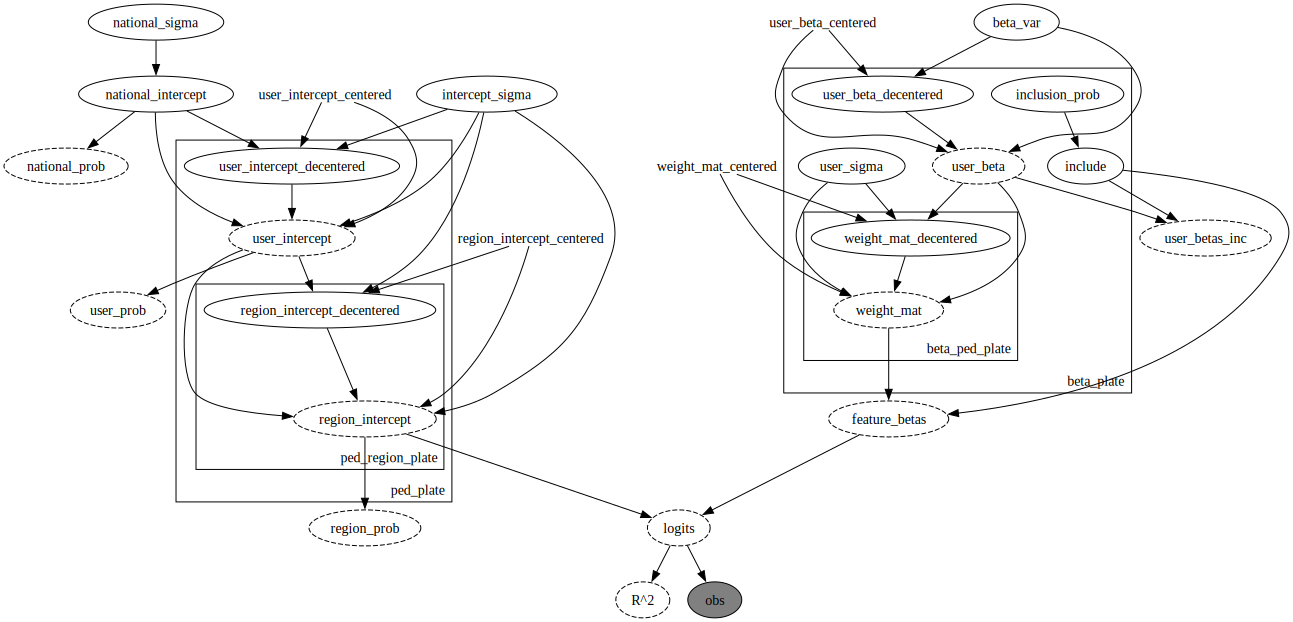

In [93]:
g = numpyro.render_model(
    model,
    model_args=(features, jnp.array(fit_data["WEIGHT"]), Y),
    render_distributions=False,
    render_params=True,
    filename="paper/images/model_graph.png",
)
g

In [58]:
weights = jnp.array(fit_data["WEIGHT"])
prior_predictive = Predictive(model, num_samples=1000)

new_key = jax.random.PRNGKey(1982)
pred = prior_predictive(new_key, features, weights)["obs"]


Text(0.5, 1.0, 'Prior Predictive Check')

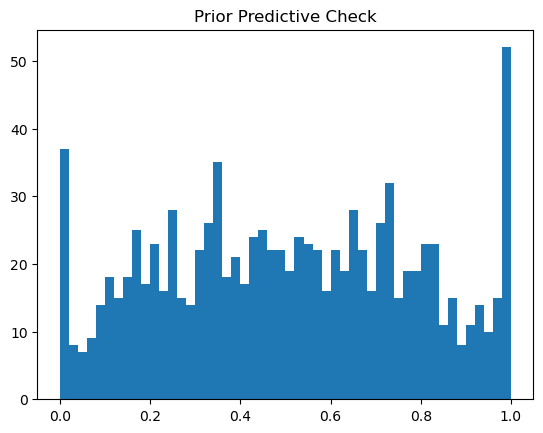

In [59]:
plt.hist(np.mean(pred, axis=1), bins=50)
plt.title("Prior Predictive Check")

In [29]:
# mcmc = numpyro.infer.MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=4)
mcmc = MCMC(DiscreteHMCGibbs(NUTS(model), modified=True), num_warmup=500, num_samples=500, num_chains=4)
mcmc.run(jax.random.PRNGKey(44), features, weights, Y)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
region_names = preprocessor.transformers_[0][1].categories_[0]
feature_names = preprocessor.transformers_[1][1].get_feature_names_out()[1:]

trace = az.from_numpyro(
    mcmc,
    coords={
        "region": region_names,
        "feature": feature_names,
        "is_ped": ["Cyclist", "Pedestrian"],
    },
    dims={
        "user_intercept": ["is_ped"],
        "region_intercept": ["region", "is_ped"],
        "feature_betas": ["is_ped", "feature"],
        "include": ["feature"],
        "user_beta": ["feature"],
        "user_betas_inc": ["feature"],
        "user_prob": ["is_ped"],
        "region_prob": ["region", "is_ped"],
    },
)

# Results Compilation

## Traceplot

/opt/anaconda3/envs/traffic/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/anaconda3/envs/traffic/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


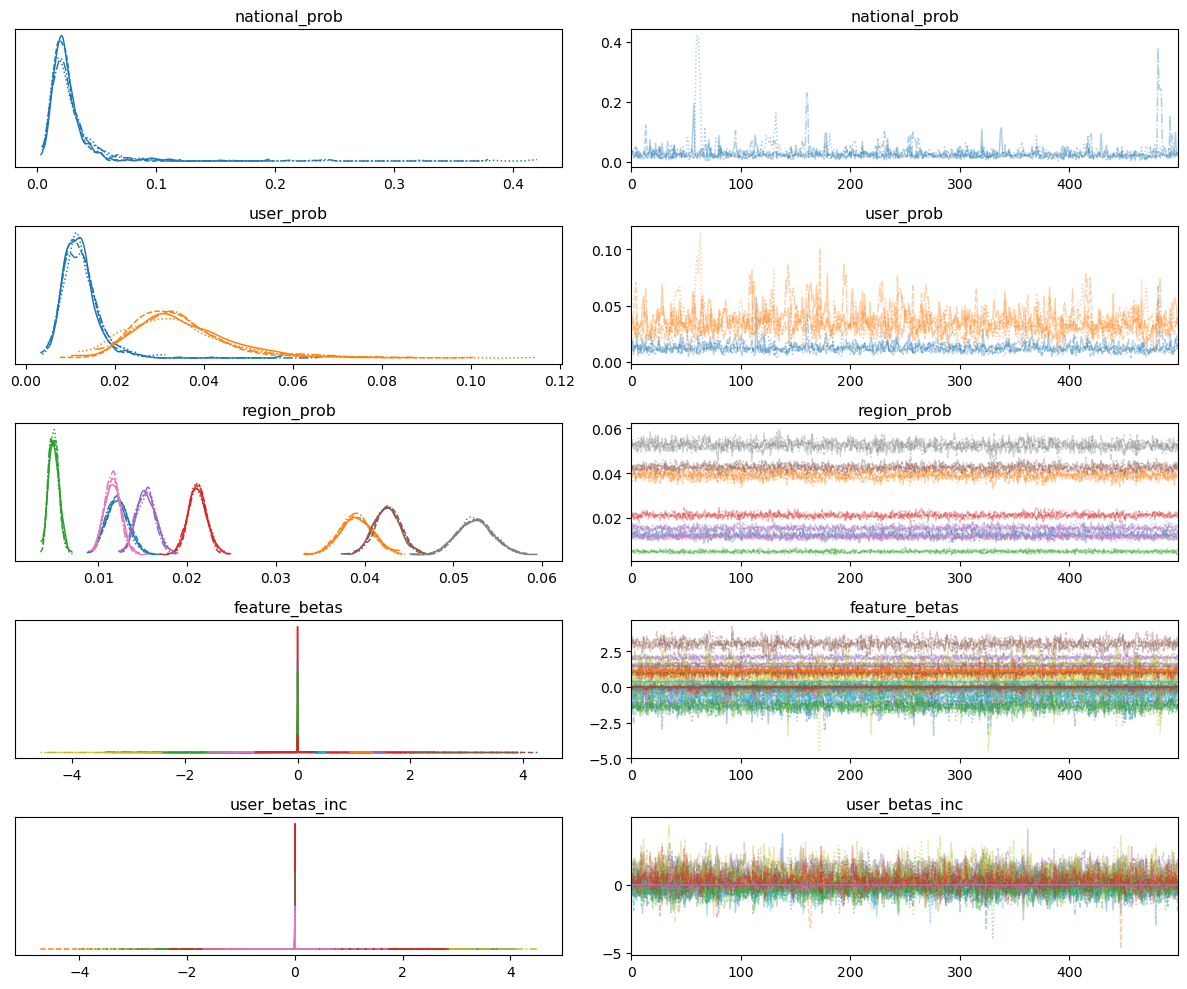

In [61]:
az.plot_trace(trace, var_names=["national_prob", "user_prob", "region_prob", "feature_betas", "user_betas_inc"], compact=True)
# az.plot_trace(trace, var_names=["national_intercept", "user_intercept", "region_intercept", "feature_betas"], compact=True)
plt.tight_layout()


Text(0.5, 1.0, 'Posterior $R^2$')

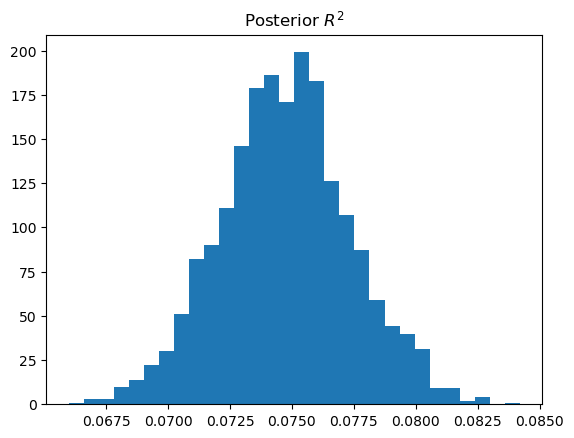

In [62]:
plt.hist(trace.posterior["R^2"].values.flatten(), bins=30)
plt.title("Posterior $R^2$")

In [63]:
np.random.choice(Y, size=10000, replace=True, p=fit_data["WEIGHT"]/fit_data["WEIGHT"].sum()).mean()

0.066

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

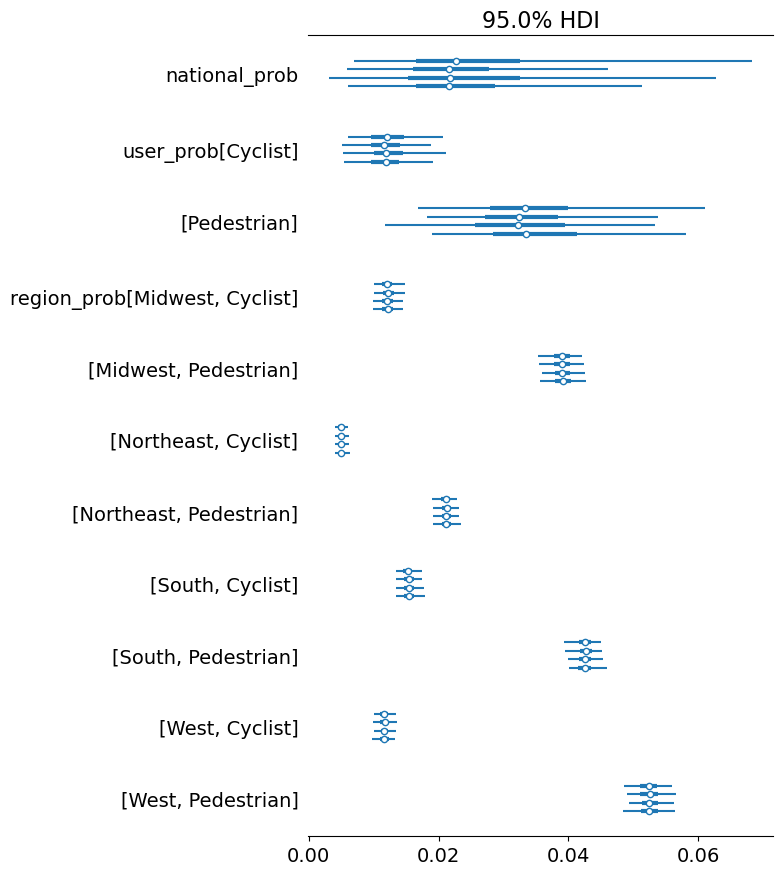

In [64]:
az.plot_forest(
    trace,
    var_names=["national_prob", "user_prob", "region_prob"],
    combined=False,
    hdi_prob=0.95,
)

## Bodyclass Comparison

/opt/anaconda3/envs/traffic/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


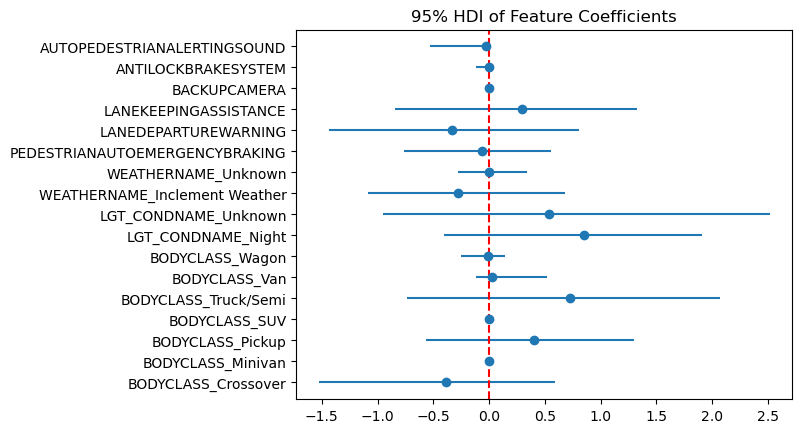

In [65]:
import re

# chat GPT generated code here to deal with annoying regex
summary_data = az.summary(trace, var_names=["user_betas_inc"], hdi_prob=0.95)

fig, ax = plt.subplots()
# Extract the names in the index from between the brackets using regex
summary_data.index = summary_data.index.str.extract(r'\[(.*?)\]', expand=False)
summary_data.index = summary_data.index.str.replace("_True", "")

err = [
    np.maximum(0, summary_data["mean"] - summary_data["hdi_2.5%"]), 
    np.maximum(0, summary_data["hdi_97.5%"] - summary_data["mean"])
]

ax.errorbar(
    y=summary_data.index,
    x=summary_data["mean"],
    xerr=err,
    fmt="o",
)
ax.set_title("95% HDI of Feature Coefficients")
ax.axvline(x=0, color='red', linestyle='--')


/opt/anaconda3/envs/traffic/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/traffic/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


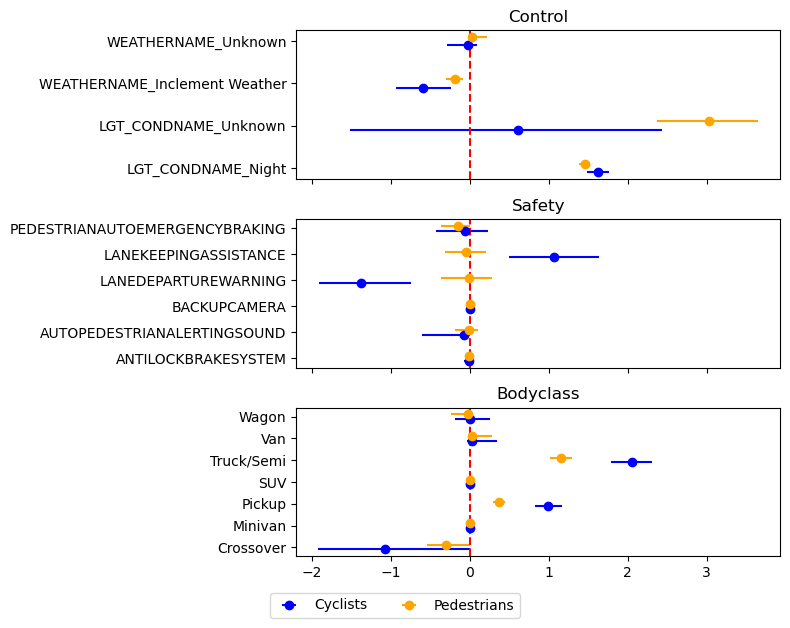

In [ ]:
# break this data out by cyclist and pedestrian and check again
summary_data = (
    pl.DataFrame(
        az.summary(trace, var_names=["feature_betas"], hdi_prob=0.95).reset_index(
            names="colname"
        )
    )
    .with_columns(
        pl.col("colname").str.contains("Cyclist").alias("cyclist"),
        pl.col("colname")
        .str.extract(r"\[*, (.*?)\]")
        .replace("_True", "")
        .alias("feature"),
    )
    .with_columns(
        pl.when(pl.col("feature").str.contains("BODYCLASS"))
        .then(pl.lit("Bodyclass"))
        .when(pl.col("feature").str.contains("WEATHERNAME"))
        .then(pl.lit("Control"))
        .when(pl.col("feature").str.contains("LGT_CONDNAME"))
        .then(pl.lit("Control"))
        .otherwise(pl.lit("Safety"))
        .alias("feature_group"),
        pl.col("feature").str.replace("BODYCLASS_|_True", "").alias("feature"),
    )
    .sort("feature_group")
)


# this plot was generated by CoPilot. I made some adjustments here and there, but
# credit where credit is due, it made making this complicated plot much, much simpler.
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
for (i, (feature_group, grp)), ax in zip(enumerate(summary_data.group_by("feature_group")), axs.reshape(-1)):
    cyclist_data = grp.filter(pl.col("cyclist") == True).sort("feature")
    pedestrian_data = grp.filter(pl.col("cyclist") == False).sort("feature")
    feature_names = pedestrian_data["feature"]

    cyclist_err = [
        np.maximum(0, cyclist_data["mean"] - cyclist_data["hdi_2.5%"]), 
        np.maximum(0, cyclist_data["hdi_97.5%"] - cyclist_data["mean"])
    ]
    pedestrian_err = [
        np.maximum(0, pedestrian_data["mean"] - pedestrian_data["hdi_2.5%"]), 
        np.maximum(0, pedestrian_data["hdi_97.5%"] - pedestrian_data["mean"])
    ]

    # Plot error bars for cyclists
    ax.errorbar(
        y=np.arange(len(feature_names)) - 0.1,  # Shift y-axis positions for cyclists
        x=cyclist_data["mean"],
        xerr=cyclist_err,
        fmt="o",
        label="Cyclists",
        color="blue"
    )

    # Plot error bars for pedestrians
    ax.errorbar(
        y=np.arange(len(feature_names)) + 0.1,  # Shift y-axis positions for pedestrians
        x=pedestrian_data["mean"],
        xerr=pedestrian_err,
        fmt="o",
        label="Pedestrians",
        color="orange"
    )

    # Set y-axis labels
    ax.set_yticks(np.arange(cyclist_data.shape[0]))
    ax.set_yticklabels(feature_names)
    ax.set_title(f"{feature_group[0]}")
    ax.axvline(x=0, color='red', linestyle='--')
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Feature Inclusion Probabilities')

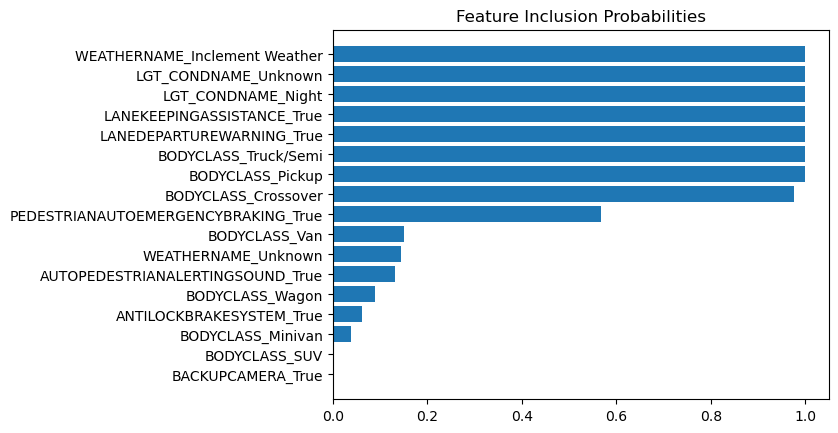

In [168]:
includes = trace.posterior["include"].mean(dim=["chain", "draw"]).to_dataframe().reset_index().sort_values(["include", "feature"], ascending=True)

fig, ax = plt.subplots()
ax.barh(includes["feature"], includes["include"])
ax.set_title("Feature Inclusion Probabilities")

<xarray.DataArray 'logits' ()>
array(0.1096125, dtype=float32)


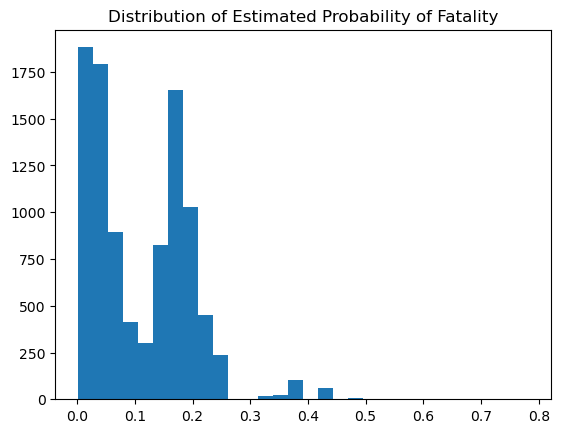

In [211]:
probs = np.exp(trace.posterior["logits"])/(1+np.exp(trace.posterior["logits"]))
plt.hist(probs.mean(dim=["chain", "draw"]), bins=30)
plt.title("Distribution of Estimated Probability of Fatality")

